In [1]:
# Key Concepts
'''
1. Forward problem: θ → x (simulation)
2. Inverse problem: x → θ (what we're solving)
3. Posterior: P(θ|x) probability distribution over parameters
4. Prior: Initial assumptions about parameter ranges
'''
import pandas as pd
import numpy as np
import sys

# seaparate into train and test set.
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
#from torch.distributions import Uniform, ExpTransform, TransformedDistribution #, AffineTransform
import torch.nn as nn
from sklearn.preprocessing import Normalizer
import joblib
import os 
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

from sbi.utils.user_input_checks import process_prior

sys.path.append("/disk/xray15/aem2/camels/proj1/")
from setup_params_LH import plot_uvlf, plot_colour
from setup_params_LH import *
from priors import initialise_priors
from variables_config import n_bins_lf, n_bins_colour #, colour_limits, uvlf_limits

# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
model = "IllustrisTNG"
spec_type = "attenuated"
sps = "BC03"
# 084 = 0.1, 060=1.05, 052=1.48, 044=2
snap = ['086'] # ['044', '052', '060',
bands = "all" # or just GALEX?

# lets try UVLF and colours this time.
colours = True  
luminosity_functions = True
name = f"{model}_{bands}_{sps}_{spec_type}_{n_bins_lf}_{n_bins_colour}"

# initialize CAMELS and load parameter info using camels.py
cam = camels(model=model, sim_set='LH')

if colours and not luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/6pams/IllustrisTNG/LH/models/colours_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/6pams/IllustrisTNG/LH/test/sbi_plots/colours_only/"
    
elif luminosity_functions and not colours:
    model_out_dir = "/disk/xray15/aem2/data/6pams/IllustrisTNG/LH/models/lf_only/"
    plots_out_dir = "/disk/xray15/aem2/data/6pams/IllustrisTNG/LH/test/sbi_plots/lf_only"

elif colours and luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/6pams/IllustrisTNG/LH/models/colours_lfs/"
    plots_out_dir = "/disk/xray15/aem2/plots/6pams/IllustrisTNG/LH/test/sbi_plots/colours_lfs/"

# You might want to add an else for safety:
else:
    raise ValueError("At least one of colours or luminosity_functions must be True")

print("Saving model in ", model_out_dir)
print("Saving plots in ", plots_out_dir)


ModuleNotFoundError: No module named 'torch'

In [2]:
# Check available snapshots first
available_snaps = get_available_snapshots()
print(f"Available snapshots: {available_snaps}")

Available snapshots: ['044', '052', '060', '086']


### Chris version of sbi:


In [3]:

prior = initialise_priors(device=device, astro=True, dust=False)
theta, x = get_theta_x(
    # photo_dir=f"/mnt/ceph/users/clovell/CAMELS_photometry/{model}/",
    photo_dir=f"/disk/xray15/aem2/data/6pams/",
    spec_type=spec_type,
    model=model,
    snap=snap,
    sps=sps,
    n_bins_lf=n_bins_lf,
    n_bins_colour=n_bins_colour,
    colours=colours,
    luminosity_functions=luminosity_functions,
    device=device,
)


/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 6 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:209: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  warnings.warn(


Data shapes:
x_all shape: (1000, 36)
theta shape: (1000, 6)

X_all statistics:
Mean: -2.8155
Std: 2.4683
Min: -6.0000
Max: 1.2470

Theta statistics:

Parameter 1:
Mean: 0.3000
Std: 0.1155
Min: 0.1002
Max: 0.4998

Parameter 2:
Mean: 0.8000
Std: 0.1155
Min: 0.6002
Max: 0.9998

Parameter 3:
Mean: 1.3525
Std: 1.0221
Min: 0.2503
Max: 3.9945

Parameter 4:
Mean: 1.3525
Std: 1.0221
Min: 0.2503
Max: 3.9945

Parameter 5:
Mean: 1.0820
Std: 0.4263
Min: 0.5003
Max: 1.9986

Parameter 6:
Mean: 1.0820
Std: 0.4263
Min: 0.5003
Max: 1.9986


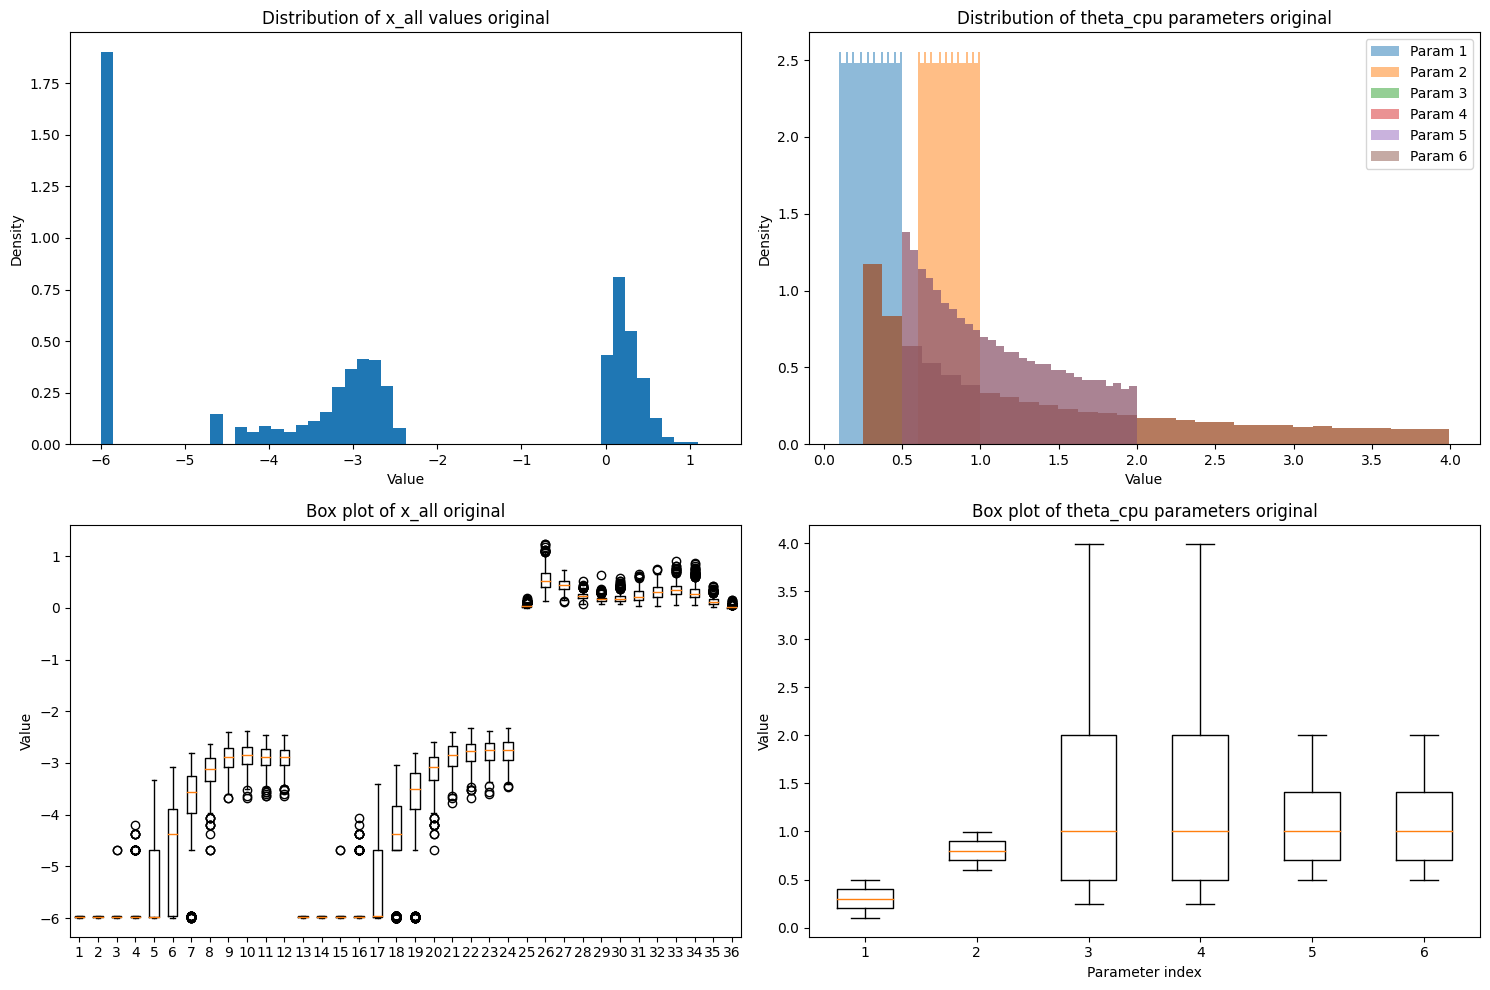

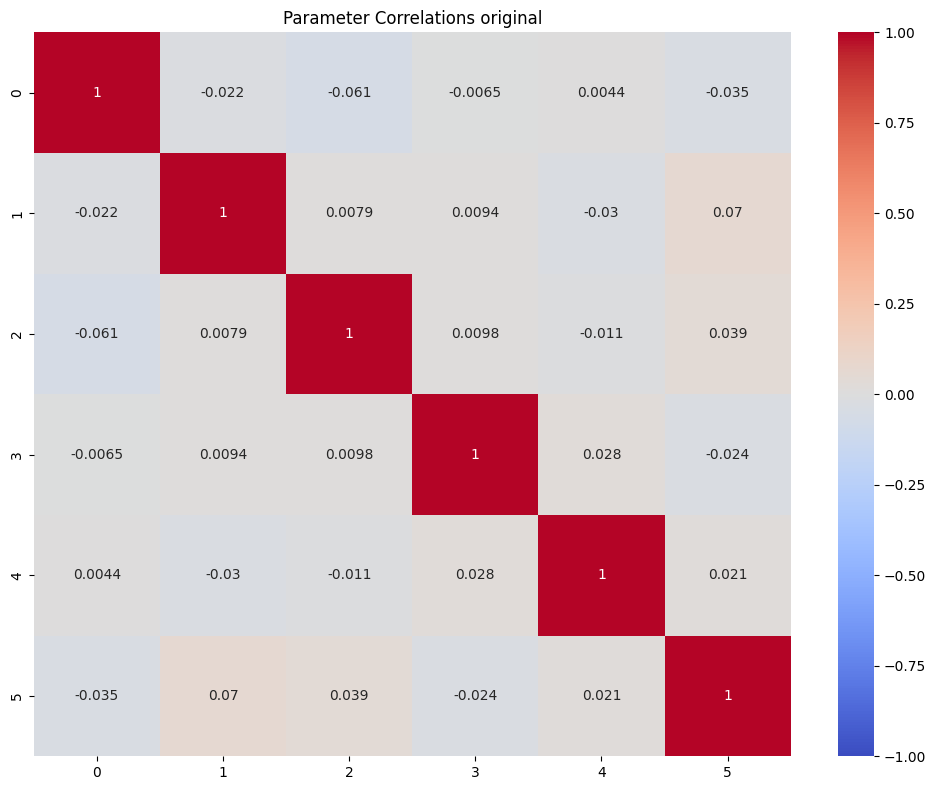

In [25]:
# First get the raw data
x_cpu = x
theta_cpu = theta.cpu().numpy()

# Print basic statistics
print("Data shapes:")
print(f"x_all shape: {x_cpu.shape}")
print(f"theta shape: {theta_cpu.shape}")

print("\nX_all statistics:")
print(f"Mean: {x_cpu.mean():.4f}")
print(f"Std: {x_cpu.std():.4f}")
print(f"Min: {x_cpu.min():.4f}")
print(f"Max: {x_cpu.max():.4f}")

print("\nTheta statistics:")
for i in range(theta_cpu.shape[1]):
    print(f"\nParameter {i+1}:")
    print(f"Mean: {theta_cpu[:, i].mean():.4f}")
    print(f"Std: {theta_cpu[:, i].std():.4f}")
    print(f"Min: {theta_cpu[:, i].min():.4f}")
    print(f"Max: {theta_cpu[:, i].max():.4f}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot x_all distribution
axes[0,0].hist(x_cpu.flatten(), bins=50, density=True)
axes[0,0].set_title('Distribution of x_all values original')
axes[0,0].set_xlabel('Value')
axes[0,0].set_ylabel('Density')

# Plot theta distributions
for i in range(theta_cpu.shape[1]):
    axes[0,1].hist(theta_cpu[:, i], bins=30, alpha=0.5, density=True, label=f'Param {i+1}')
axes[0,1].set_title('Distribution of theta_cpu parameters original')
axes[0,1].set_xlabel('Value')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()

# Box plot for x_all
axes[1,0].boxplot(x_cpu)
axes[1,0].set_title('Box plot of x_all original')
axes[1,0].set_ylabel('Value')

# Box plot for theta_cpu parameters
axes[1,1].boxplot([theta_cpu[:, i] for i in range(theta_cpu.shape[1])])
axes[1,1].set_title('Box plot of theta_cpu parameters original')
axes[1,1].set_xlabel('Parameter index')
axes[1,1].set_ylabel('Value')

plt.tight_layout()
plt.show()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(np.corrcoef(theta_cpu.T), 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0)
plt.title('Parameter Correlations original')
plt.tight_layout()
plt.show()

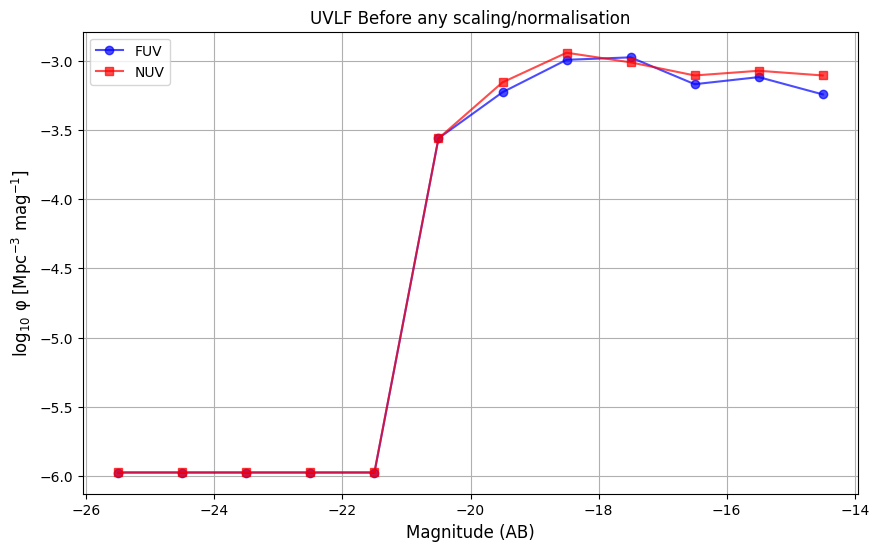

In [21]:
if luminosity_functions:
    fig = plot_uvlf(x)
    plt.savefig('/disk/xray15/aem2/plots/6pams/IllustrisTNG/LH/test/LFs_test/uvlf_check.png')
    plt.title('UVLF Before any scaling/normalisation')
    plt.show()

Color range: [-0.5, 3.5]
Distribution range: [0.02, 0.55]


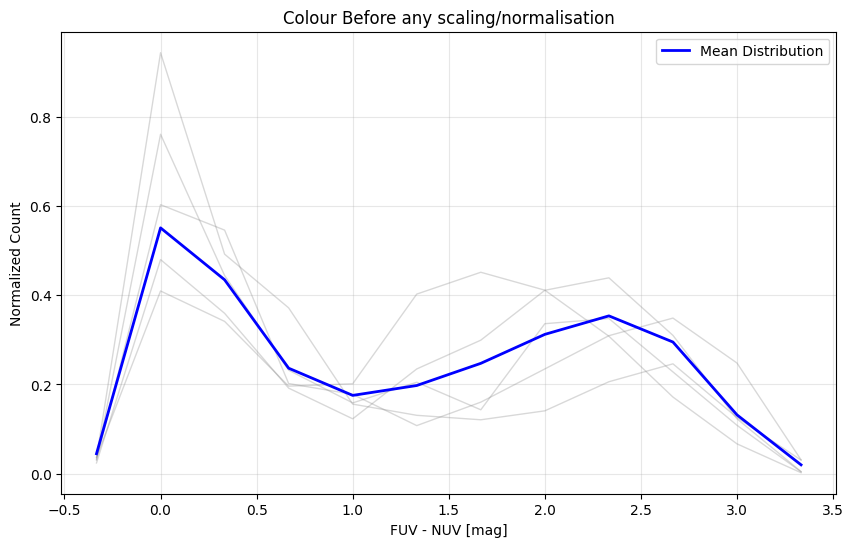

In [20]:
if colours:
    fig = plot_colour(x)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colour_check.png')
    plt.title('Colour Before any scaling/normalisation')
    plt.show()

In [6]:

x_all = np.array([np.hstack(_x) for _x in x])

# import test mask
test_mask = np.loadtxt("/disk/xray15/aem2/data/6pams/IllustrisTNG/LH/test_mask.txt", dtype=bool)

# # Make sure no constant variables, to avoid nan loss with lampe NDE models
# x_all[x_all == 0.0] = np.array(
#     np.random.rand(np.sum((x_all == 0.0))) * 1e-10
# )


In [7]:
# using normaliser:
norm = Normalizer()
x_all_norm = torch.tensor(
    norm.fit_transform(X=x_all),
    # x_all,
    dtype=torch.float32,
    device=device, 
)

joblib.dump(norm, f'/disk/xray15/aem2/data/6pams/IllustrisTNG/LH/models/{name}_scaler.save')


# test_mask = np.random.rand(1000) > 0.9
# np.savetxt('../data/test_mask.txt', test_mask, fmt='%i')


['/disk/xray15/aem2/data/6pams/IllustrisTNG/LH/models/IllustrisTNG_all_BC03_attenuated_13_13_scaler.save']

In [8]:
# using scaler:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_all_scal = torch.tensor(
    scaler.fit_transform(X=x_all),
    dtype=torch.float32,
    device=device
)

Data shapes:
x_all shape: (1000, 36)
theta shape: (1000, 6)

X_all statistics:
Mean: -0.1254
Std: 0.1098
Min: -0.2957
Max: 0.0610

Theta statistics:

Parameter 1:
Mean: 0.3000
Std: 0.1155
Min: 0.1002
Max: 0.4998

Parameter 2:
Mean: 0.8000
Std: 0.1155
Min: 0.6002
Max: 0.9998

Parameter 3:
Mean: 1.3525
Std: 1.0221
Min: 0.2503
Max: 3.9945

Parameter 4:
Mean: 1.3525
Std: 1.0221
Min: 0.2503
Max: 3.9945

Parameter 5:
Mean: 1.0820
Std: 0.4263
Min: 0.5003
Max: 1.9986

Parameter 6:
Mean: 1.0820
Std: 0.4263
Min: 0.5003
Max: 1.9986


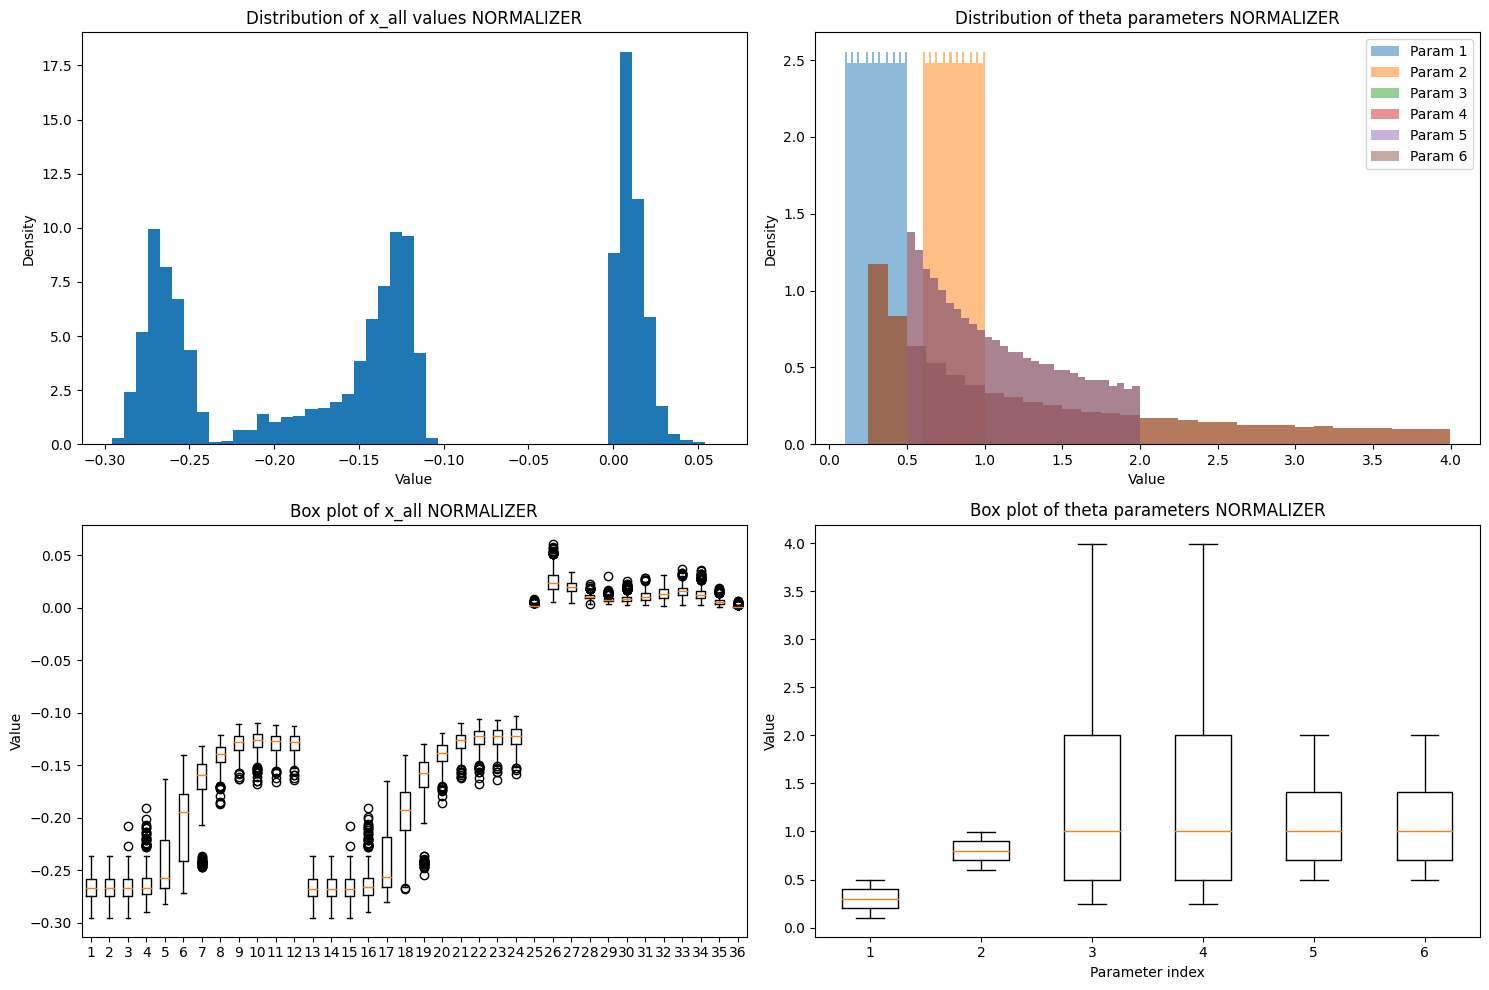

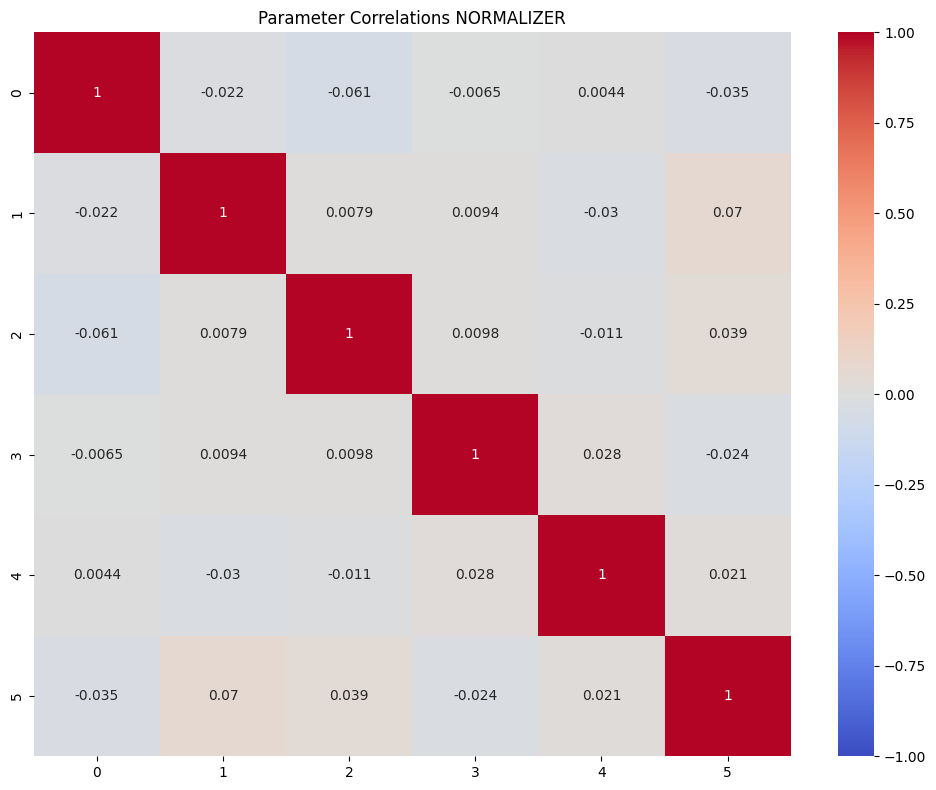

In [14]:
# First move data to CPU and convert to numpy
x_all_norm_np = x_all_norm.cpu().numpy()
theta_np = theta.cpu().numpy()

# Print basic statistics
print("Data shapes:")
print(f"x_all shape: {x_all_norm_np.shape}")
print(f"theta shape: {theta_np.shape}")

print("\nX_all statistics:")
print(f"Mean: {x_all_norm_np.mean():.4f}")
print(f"Std: {x_all_norm_np.std():.4f}")
print(f"Min: {x_all_norm_np.min():.4f}")
print(f"Max: {x_all_norm_np.max():.4f}")

print("\nTheta statistics:")
for i in range(theta_np.shape[1]):
    print(f"\nParameter {i+1}:")
    print(f"Mean: {theta_np[:, i].mean():.4f}")
    print(f"Std: {theta_np[:, i].std():.4f}")
    print(f"Min: {theta_np[:, i].min():.4f}")
    print(f"Max: {theta_np[:, i].max():.4f}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot x_all distribution
axes[0,0].hist(x_all_norm_np.flatten(), bins=50, density=True)
axes[0,0].set_title('Distribution of x_all values NORMALIZER')
axes[0,0].set_xlabel('Value')
axes[0,0].set_ylabel('Density')

# Plot theta distributions
for i in range(theta_np.shape[1]):
    axes[0,1].hist(theta_np[:, i], bins=30, alpha=0.5, density=True, label=f'Param {i+1}')
axes[0,1].set_title('Distribution of theta parameters NORMALIZER')
axes[0,1].set_xlabel('Value')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()

# Box plot for x_all
axes[1,0].boxplot(x_all_norm_np)
axes[1,0].set_title('Box plot of x_all NORMALIZER')
axes[1,0].set_ylabel('Value')

# Box plot for theta parameters
axes[1,1].boxplot([theta_np[:, i] for i in range(theta_np.shape[1])])
axes[1,1].set_title('Box plot of theta parameters NORMALIZER')
axes[1,1].set_xlabel('Parameter index')
axes[1,1].set_ylabel('Value')

plt.tight_layout()
plt.show()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(np.corrcoef(theta_np.T), 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0)
plt.title('Parameter Correlations NORMALIZER')
plt.tight_layout()
plt.show()

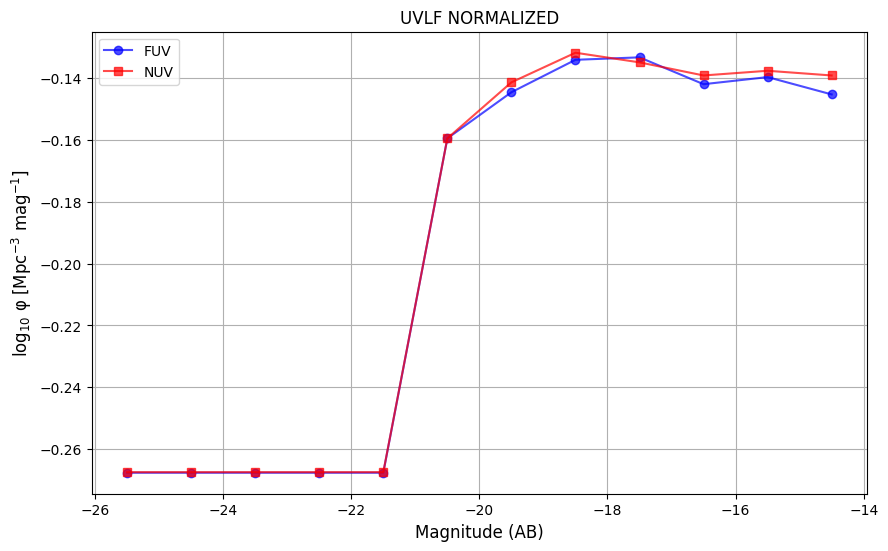

In [17]:
if luminosity_functions:
    fig = plot_uvlf(x_all_norm_np)
    plt.savefig('/disk/xray15/aem2/plots/6pams/IllustrisTNG/LH/test/LFs_test/uvlf_check.png')
    plt.title('UVLF NORMALIZED')
    plt.show()

Color range: [-0.5, 3.5]
Distribution range: [0.00, 0.02]


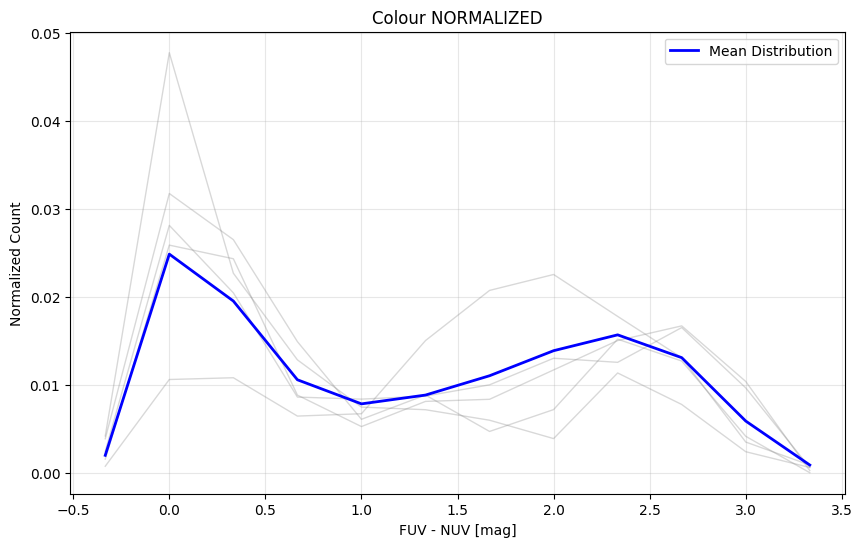

In [16]:
if colours:
    fig = plot_colour(x_all_norm_np)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colour_check.png')
    plt.title('Colour NORMALIZED')
    plt.show()

Data shapes:
x_all shape: (1000, 36)
theta shape: (1000, 6)

X_all statistics:
Mean: -0.0000
Std: 1.0000
Min: -4.6825
Max: 21.8966

Theta statistics:

Parameter 1:
Mean: 0.3000
Std: 0.1155
Min: 0.1002
Max: 0.4998

Parameter 2:
Mean: 0.8000
Std: 0.1155
Min: 0.6002
Max: 0.9998

Parameter 3:
Mean: 1.3525
Std: 1.0221
Min: 0.2503
Max: 3.9945

Parameter 4:
Mean: 1.3525
Std: 1.0221
Min: 0.2503
Max: 3.9945

Parameter 5:
Mean: 1.0820
Std: 0.4263
Min: 0.5003
Max: 1.9986

Parameter 6:
Mean: 1.0820
Std: 0.4263
Min: 0.5003
Max: 1.9986


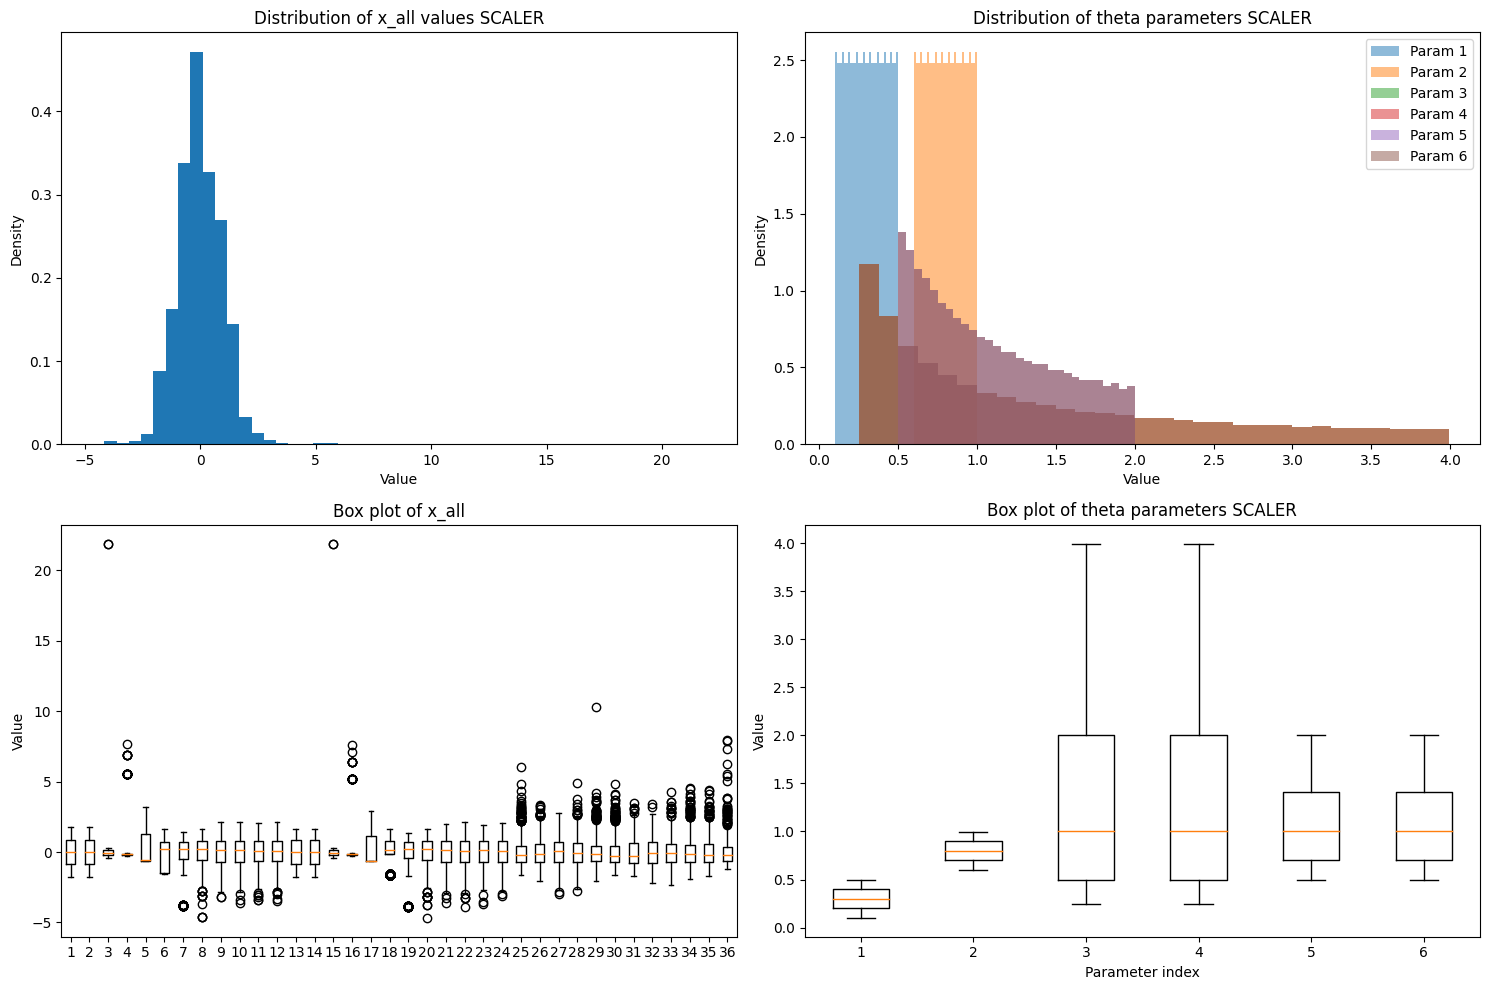

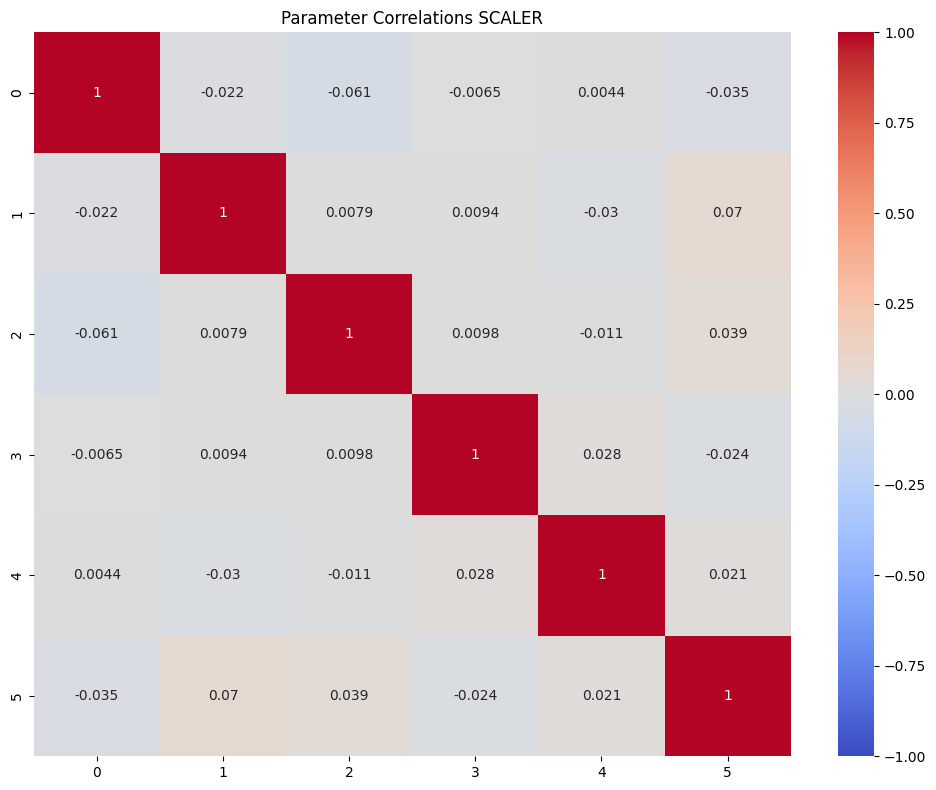

In [15]:
# First move data to CPU and convert to numpy
x_all_scal_np = x_all_scal.cpu().numpy()

# Print basic statistics
print("Data shapes:")
print(f"x_all shape: {x_all_scal_np.shape}")
print(f"theta shape: {theta_np.shape}")

print("\nX_all statistics:")
print(f"Mean: {x_all_scal_np.mean():.4f}")
print(f"Std: {x_all_scal_np.std():.4f}")
print(f"Min: {x_all_scal_np.min():.4f}")
print(f"Max: {x_all_scal_np.max():.4f}")

print("\nTheta statistics:")
for i in range(theta_np.shape[1]):
    print(f"\nParameter {i+1}:")
    print(f"Mean: {theta_np[:, i].mean():.4f}")
    print(f"Std: {theta_np[:, i].std():.4f}")
    print(f"Min: {theta_np[:, i].min():.4f}")
    print(f"Max: {theta_np[:, i].max():.4f}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot x_all distribution
axes[0,0].hist(x_all_scal_np.flatten(), bins=50, density=True)
axes[0,0].set_title('Distribution of x_all values SCALER')
axes[0,0].set_xlabel('Value')
axes[0,0].set_ylabel('Density')

# Plot theta distributions
for i in range(theta_np.shape[1]):
    axes[0,1].hist(theta_np[:, i], bins=30, alpha=0.5, density=True, label=f'Param {i+1}')
axes[0,1].set_title('Distribution of theta parameters SCALER')
axes[0,1].set_xlabel('Value')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()

# Box plot for x_all
axes[1,0].boxplot(x_all_scal_np)
axes[1,0].set_title('Box plot of x_all')
axes[1,0].set_ylabel('Value')

# Box plot for theta parameters
axes[1,1].boxplot([theta_np[:, i] for i in range(theta_np.shape[1])])
axes[1,1].set_title('Box plot of theta parameters SCALER')
axes[1,1].set_xlabel('Parameter index')
axes[1,1].set_ylabel('Value')

plt.tight_layout()
plt.show()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(np.corrcoef(theta_np.T), 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0)
plt.title('Parameter Correlations SCALER')
plt.tight_layout()
plt.show()

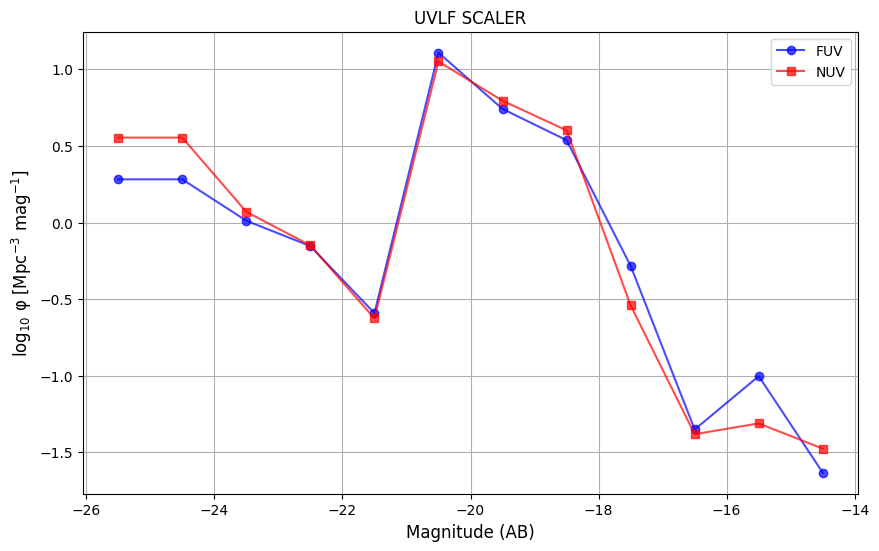

In [18]:
if luminosity_functions:
    fig = plot_uvlf(x_all_scal_np)
    plt.savefig('/disk/xray15/aem2/plots/6pams/IllustrisTNG/LH/test/LFs_test/uvlf_check.png')
    plt.title('UVLF SCALER')
    plt.show()

Color range: [-0.5, 3.5]
Distribution range: [-0.00, 0.00]


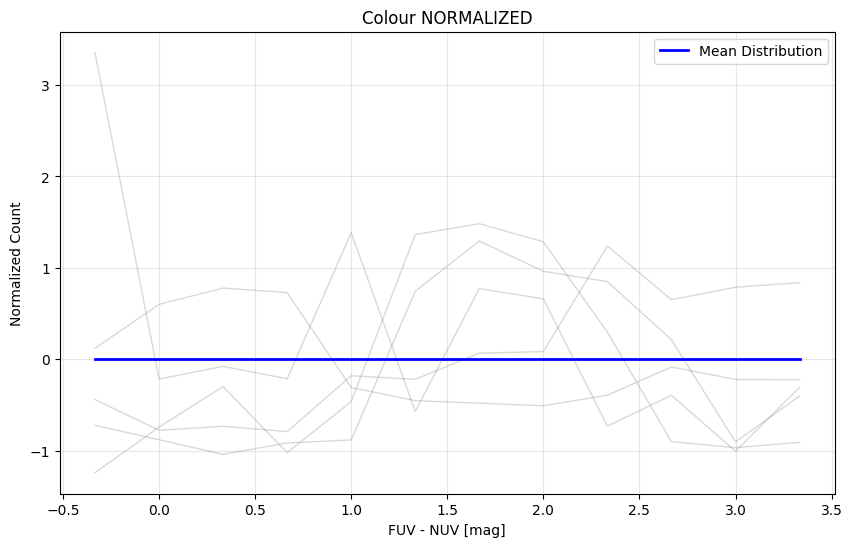

In [19]:
if colours:
    fig = plot_colour(x_all_scal_np)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colour_check.png')
    plt.title('Colour NORMALIZED')
    plt.show()

In [49]:
def scale_by_groups(x, n_bins_lf=13, n_bins_colour=13):
    # Ensure input is on CPU and numpy
    if torch.is_tensor(x):
        x = x.cpu().numpy()
    
    # Split data into FUV, NUV, and color components
    fuv_data = x[:, :n_bins_lf]
    nuv_data = x[:, n_bins_lf:2*n_bins_lf]
    color_data = x[:, 2*n_bins_lf:]
    
    # Scale each component independently to preserve relative relationships
    def min_max_scale(data):
        return (data - data.min()) / (data.max() - data.min())
    
    # Scale and recombine
    x_scaled = np.hstack([
        min_max_scale(fuv_data),
        min_max_scale(nuv_data),
        min_max_scale(color_data)
    ])
    
    return x_scaled

def scale_by_groups_v2(x, n_bins_lf=13, n_bins_colour=13):
    # Ensure input is on CPU and numpy
    if torch.is_tensor(x):
        x = x.cpu().numpy()
    
    # Split data into UVLF and color components
    uvlf_data = x[:, :2*n_bins_lf]  # Keep FUV and NUV together
    color_data = x[:, 2*n_bins_lf:]
    
    # Scale UVLF data together to preserve relationships
    uvlf_min = uvlf_data.min()
    uvlf_max = uvlf_data.max()
    uvlf_scaled = (uvlf_data - uvlf_min) / (uvlf_max - uvlf_min)
    
    # Scale color data separately
    color_min = color_data.min()
    color_max = color_data.max()
    color_scaled = (color_data - color_min) / (color_max - color_min)
    
    # Combine
    x_scaled = np.hstack([uvlf_scaled, color_scaled])
    return x_scaled


def scale_by_groups_v3(x, n_bins_lf=13, n_bins_colour=13):
    if torch.is_tensor(x):
        x = x.cpu().numpy()
    
    # Split data
    uvlf_data = x[:, :2*n_bins_lf]
    color_data = x[:, 2*n_bins_lf:]
    
    # Log transform UVLF data first (handling negatives)
    uvlf_min = uvlf_data.min()
    uvlf_shifted = uvlf_data - uvlf_min + 1e-5  # shift to positive and add small constant
    uvlf_log = np.log10(uvlf_shifted)
    
    # Then min-max scale
    uvlf_scaled = (uvlf_log - uvlf_log.min()) / (uvlf_log.max() - uvlf_log.min())
    
    # Scale color data as before
    color_scaled = (color_data - color_data.min()) / (color_data.max() - color_data.min())
    
    return np.hstack([uvlf_scaled, color_scaled])

def scale_by_groups_v4(x, n_bins_lf=13, n_bins_colour=13):
    if torch.is_tensor(x):
        x = x.cpu().numpy()
    
    from sklearn.preprocessing import QuantileTransformer
    
    # Split data
    uvlf_data = x[:, :2*n_bins_lf]
    color_data = x[:, 2*n_bins_lf:]
    
    # Transform UVLF data
    qt = QuantileTransformer(output_distribution='uniform')
    uvlf_scaled = qt.fit_transform(uvlf_data)
    
    # Transform color data separately
    qt_color = QuantileTransformer(output_distribution='uniform')
    color_scaled = qt_color.fit_transform(color_data)
    
    return np.hstack([uvlf_scaled, color_scaled])

def scale_by_groups_v5(x, n_bins_lf=13, n_bins_colour=13):
    if torch.is_tensor(x):
        x = x.cpu().numpy()
    
    # Split data
    uvlf_data = x[:, :2*n_bins_lf]
    color_data = x[:, 2*n_bins_lf:]
    
    # For UVLF: shift to positive, log transform, then scale to 0.2-0.8 range
    uvlf_min = uvlf_data.min()
    uvlf_shifted = uvlf_data - uvlf_min + 1e-5
    uvlf_log = np.log10(uvlf_shifted)
    uvlf_scaled = (uvlf_log - uvlf_log.min()) / (uvlf_log.max() - uvlf_log.min())
    uvlf_scaled = 0.2 + (0.6 * uvlf_scaled)  # Scale to 0.2-0.8 range
    
    # For colors: scale to 0-1 range as before
    color_scaled = (color_data - color_data.min()) / (color_data.max() - color_data.min())
    
    return np.hstack([uvlf_scaled, color_scaled])

def scale_by_groups_v6(x, n_bins_lf=13, n_bins_colour=13):
    if torch.is_tensor(x):
        x = x.cpu().numpy()
    
    # Split data into UVLF and color components
    uvlf_data = x[:, :2*n_bins_lf]  # Keep FUV and NUV together
    color_data = x[:, 2*n_bins_lf:]
    
    # Scale UVLF data together to preserve relationships
    uvlf_min = uvlf_data.min()
    uvlf_max = uvlf_data.max()
    uvlf_scaled = (uvlf_data - uvlf_min) / (uvlf_max - uvlf_min)
    
    # Scale color data separately
    color_min = color_data.min()
    color_max = color_data.max()
    color_scaled = (color_data - color_min) / (color_max - color_min)
    
    # Combine
    x_scaled = np.hstack([uvlf_scaled, color_scaled])
    return x_scaled

# Apply scaling and convert to tensor on correct device
x_all_ind_scaled = torch.tensor(
    scale_by_groups_v6(x_all),
    dtype=torch.float32,
    device=device
)

Data shapes:
x_all shape: (1000, 36)
theta shape: (1000, 6)

X_all statistics:
Mean: 0.2744
Std: 0.2344
Min: 0.0000
Max: 1.0000

Theta statistics:

Parameter 1:
Mean: 0.3000
Std: 0.1155
Min: 0.1002
Max: 0.4998

Parameter 2:
Mean: 0.8000
Std: 0.1155
Min: 0.6002
Max: 0.9998

Parameter 3:
Mean: 1.3525
Std: 1.0221
Min: 0.2503
Max: 3.9945

Parameter 4:
Mean: 1.3525
Std: 1.0221
Min: 0.2503
Max: 3.9945

Parameter 5:
Mean: 1.0820
Std: 0.4263
Min: 0.5003
Max: 1.9986

Parameter 6:
Mean: 1.0820
Std: 0.4263
Min: 0.5003
Max: 1.9986


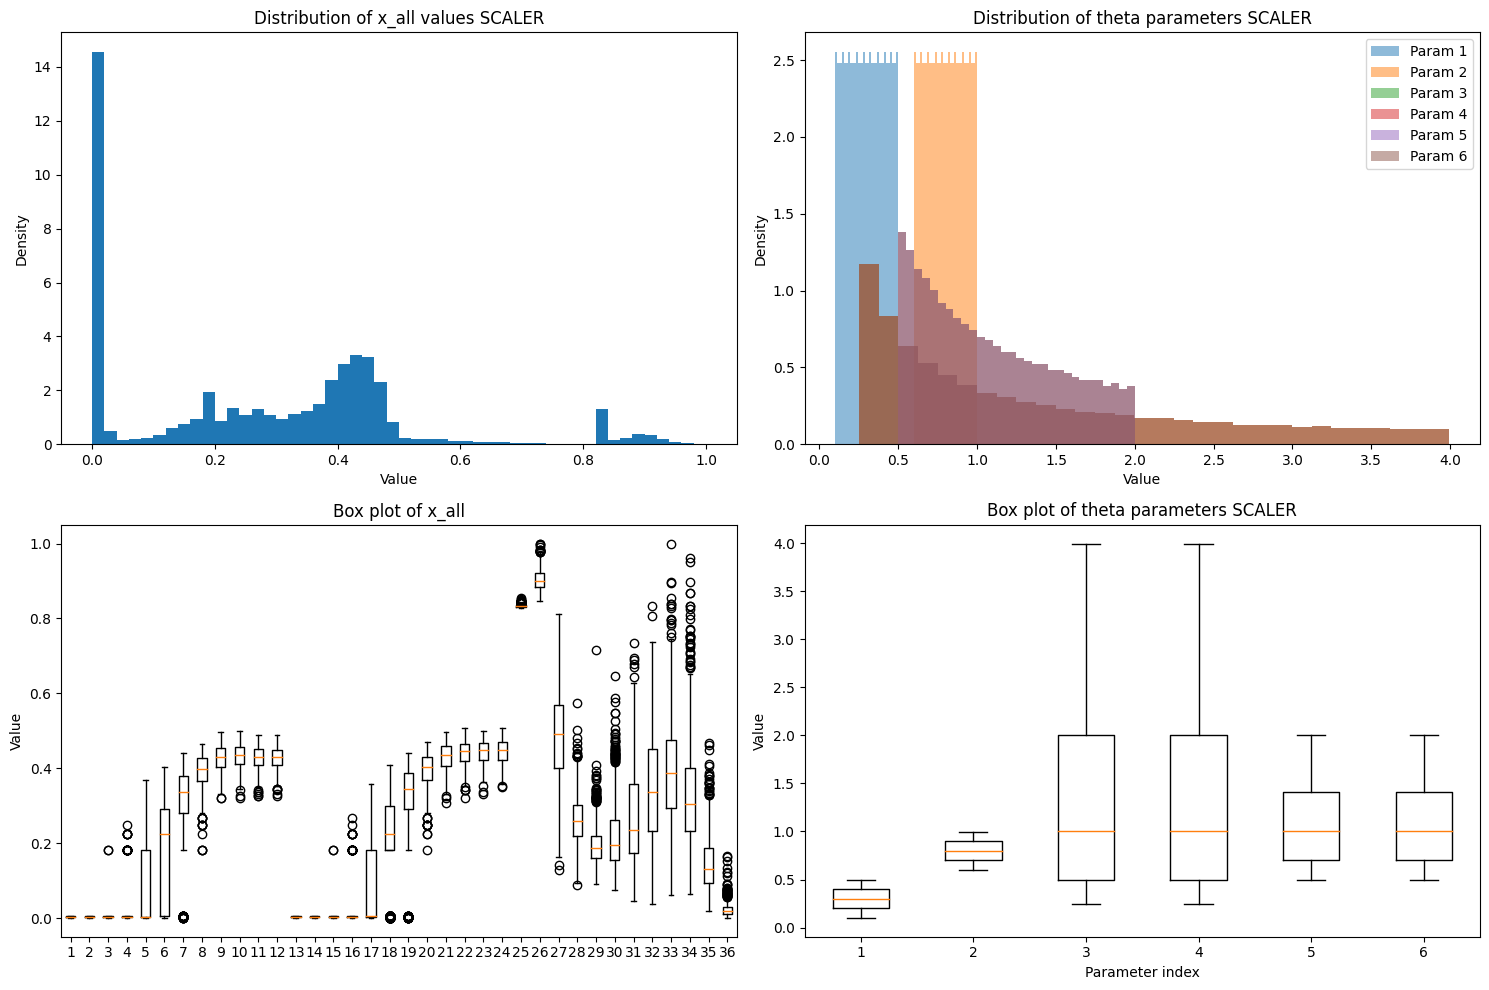

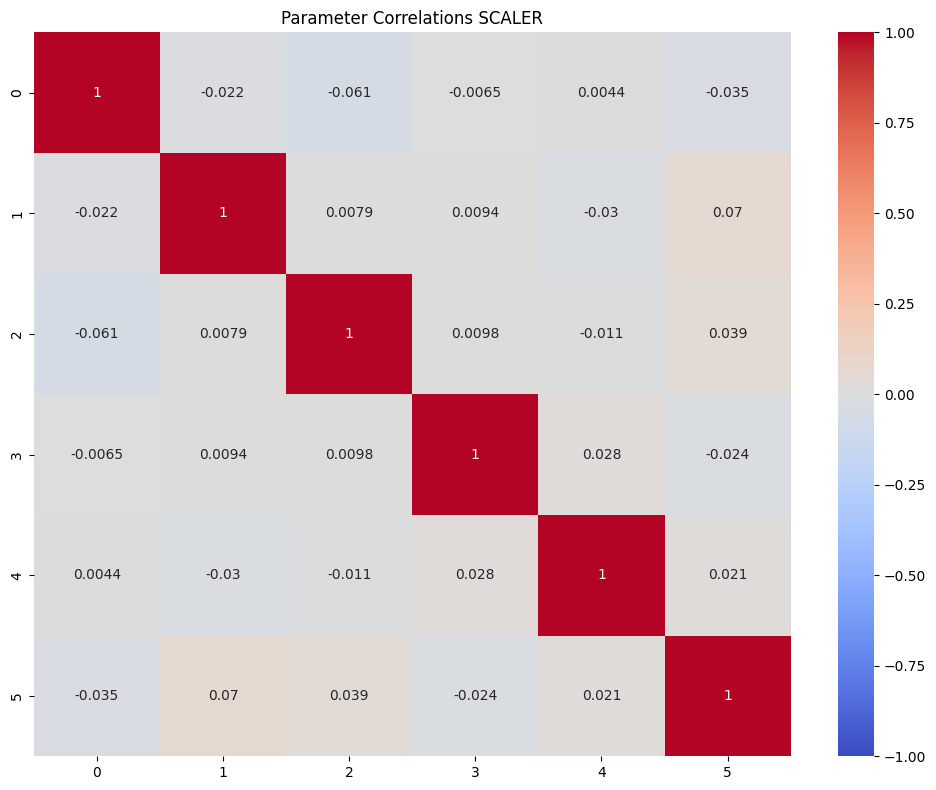

In [50]:
# First move data to CPU and convert to numpy
x_all_ind_scaled_np = x_all_ind_scaled.cpu().numpy()

# Print basic statistics
print("Data shapes:")
print(f"x_all shape: {x_all_ind_scaled_np.shape}")
print(f"theta shape: {theta_np.shape}")

print("\nX_all statistics:")
print(f"Mean: {x_all_ind_scaled_np.mean():.4f}")
print(f"Std: {x_all_ind_scaled_np.std():.4f}")
print(f"Min: {x_all_ind_scaled_np.min():.4f}")
print(f"Max: {x_all_ind_scaled_np.max():.4f}")

print("\nTheta statistics:")
for i in range(theta_np.shape[1]):
    print(f"\nParameter {i+1}:")
    print(f"Mean: {theta_np[:, i].mean():.4f}")
    print(f"Std: {theta_np[:, i].std():.4f}")
    print(f"Min: {theta_np[:, i].min():.4f}")
    print(f"Max: {theta_np[:, i].max():.4f}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot x_all distribution
axes[0,0].hist(x_all_ind_scaled_np.flatten(), bins=50, density=True)
axes[0,0].set_title('Distribution of x_all values SCALER')
axes[0,0].set_xlabel('Value')
axes[0,0].set_ylabel('Density')

# Plot theta distributions
for i in range(theta_np.shape[1]):
    axes[0,1].hist(theta_np[:, i], bins=30, alpha=0.5, density=True, label=f'Param {i+1}')
axes[0,1].set_title('Distribution of theta parameters SCALER')
axes[0,1].set_xlabel('Value')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()

# Box plot for x_all
axes[1,0].boxplot(x_all_ind_scaled_np)
axes[1,0].set_title('Box plot of x_all')
axes[1,0].set_ylabel('Value')

# Box plot for theta parameters
axes[1,1].boxplot([theta_np[:, i] for i in range(theta_np.shape[1])])
axes[1,1].set_title('Box plot of theta parameters SCALER')
axes[1,1].set_xlabel('Parameter index')
axes[1,1].set_ylabel('Value')

plt.tight_layout()
plt.show()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(np.corrcoef(theta_np.T), 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0)
plt.title('Parameter Correlations SCALER')
plt.tight_layout()
plt.show()

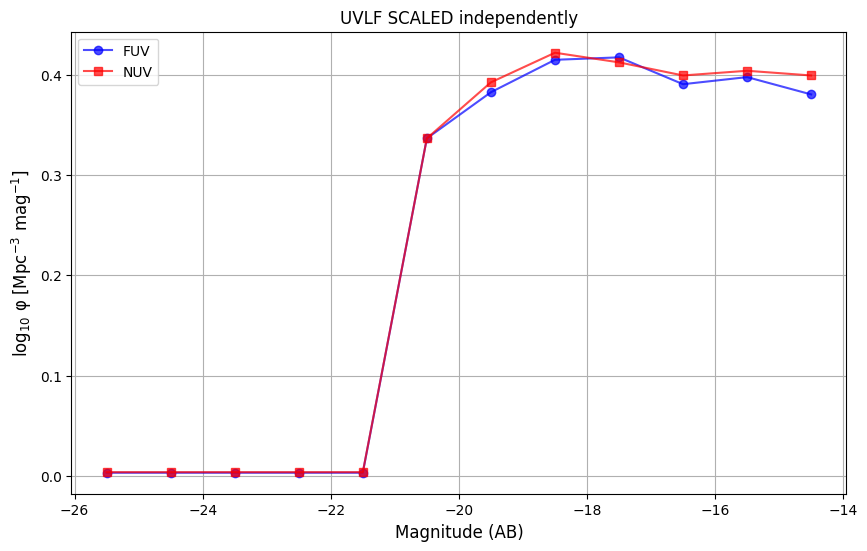

In [51]:
if luminosity_functions:
    fig = plot_uvlf(x_all_ind_scaled_np)
    plt.savefig('/disk/xray15/aem2/plots/6pams/IllustrisTNG/LH/test/LFs_test/uvlf_check.png')
    plt.title('UVLF SCALED independently')
    plt.show()

Color range: [-0.5, 3.5]
Distribution range: [0.02, 0.90]


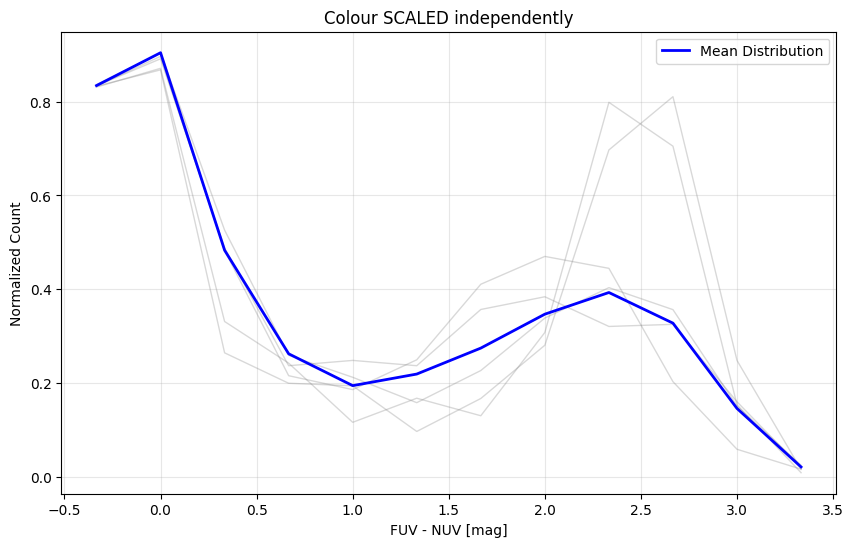

In [52]:
if colours:
    fig = plot_colour(x_all_ind_scaled_np)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colour_check.png')
    plt.title('Colour SCALED independently')
    plt.show()

In [139]:
import numpy as np
import torch

        
# class UVLFColorScaler:
#     def __init__(self, n_bins_lf=13, n_bins_colour=13):
#         self.n_bins_lf = n_bins_lf
#         self.n_bins_colour = n_bins_colour
#         # Store min/max for inverse transform
#         self.uvlf_min = None
#         self.uvlf_max = None
#         self.color_min = None
#         self.color_max = None

#     def fit_transform(self, x):
#         if torch.is_tensor(x):
#             x = x.cpu().numpy()
            
#         # Split data into UVLF and color components
#         uvlf_data = x[:, :2*self.n_bins_lf]  # Keep FUV and NUV together
#         color_data = x[:, 2*self.n_bins_lf:]
        
#         # Store parameters for inverse transform
#         self.uvlf_min = uvlf_data.min()
#         self.uvlf_max = uvlf_data.max()
#         self.color_min = color_data.min()
#         self.color_max = color_data.max()
        
#         # Scale both components to [0,1]
#         uvlf_scaled = (uvlf_data - self.uvlf_min) / (self.uvlf_max - self.uvlf_min)
#         color_scaled = (color_data - self.color_min) / (self.color_max - self.color_min)
        
#         # Combine scaled data
#         x_scaled = np.hstack([uvlf_scaled, color_scaled])
#         return x_scaled

#     def transform(self, x):
#         if torch.is_tensor(x):
#             x = x.cpu().numpy()
            
#         uvlf_data = x[:, :2*self.n_bins_lf]
#         color_data = x[:, 2*self.n_bins_lf:]
        
#         uvlf_scaled = (uvlf_data - self.uvlf_min) / (self.uvlf_max - self.uvlf_min)
#         color_scaled = (color_data - self.color_min) / (self.color_max - self.color_min)
        
#         return np.hstack([uvlf_scaled, color_scaled])

#     def inverse_transform(self, x_scaled):
#         uvlf_scaled = x_scaled[:, :2*self.n_bins_lf]
#         color_scaled = x_scaled[:, 2*self.n_bins_lf:]
        
#         uvlf_original = uvlf_scaled * (self.uvlf_max - self.uvlf_min) + self.uvlf_min
#         color_original = color_scaled * (self.color_max - self.color_min) + self.color_min
        
#         return np.hstack([uvlf_original, color_original])

class UVLFColorScaler:
    def __init__(self, n_bins_lf=13, n_bins_colour=13):
        self.n_bins_lf = n_bins_lf
        self.n_bins_colour = n_bins_colour
        self.uvlf_min = None
        self.uvlf_max = None
        self.color_min = None
        self.color_max = None

    def fit_transform(self, x):
        if torch.is_tensor(x):
            x = x.cpu().numpy()
            
        # Calculate exact feature counts
        n_uvlf_features = 26  # Based on your actual UVLF shape
        n_color_features = 10  # Based on your actual color shape
        
        # Split data using exact dimensions
        uvlf_data = x[:, :n_uvlf_features]
        color_data = x[:, n_uvlf_features:n_uvlf_features + n_color_features]
        
        # Store parameters for inverse transform
        self.uvlf_min = uvlf_data.min()
        self.uvlf_max = uvlf_data.max()
        self.color_min = color_data.min()
        self.color_max = color_data.max()
        
        # Scale both components to [0,1]
        uvlf_scaled = (uvlf_data - self.uvlf_min) / (self.uvlf_max - self.uvlf_min)
        color_scaled = (color_data - self.color_min) / (self.color_max - self.color_min)
        
        # Combine scaled data
        x_scaled = np.hstack([uvlf_scaled, color_scaled])
        return x_scaled

    def transform(self, x):
        if torch.is_tensor(x):
            x = x.cpu().numpy()
            
        n_uvlf_features = 26
        uvlf_data = x[:, :n_uvlf_features]
        color_data = x[:, n_uvlf_features:]
        
        uvlf_scaled = (uvlf_data - self.uvlf_min) / (self.uvlf_max - self.uvlf_min)
        color_scaled = (color_data - self.color_min) / (self.color_max - self.color_min)
        
        return np.hstack([uvlf_scaled, color_scaled])

    def inverse_transform(self, x_scaled):
        n_uvlf_features = 26
        uvlf_scaled = x_scaled[:, :n_uvlf_features]
        color_scaled = x_scaled[:, n_uvlf_features:]
        
        uvlf_original = uvlf_scaled * (self.uvlf_max - self.uvlf_min) + self.uvlf_min
        color_original = color_scaled * (self.color_max - self.color_min) + self.color_min
        
        return np.hstack([uvlf_original, color_original])
    
# # Initialize the scaler
# scaler = UVLFColorScaler()

# # Scale all data
# x_all_scaled = scaler.fit_transform(x_all)  # Assuming x_all is your original data

# # Convert to tensor and split using mask
# x_all_scaled = torch.tensor(x_all_scaled, dtype=torch.float32, device=device)

# Initialize the scaler
scaler = UVLFColorScaler()

# Scale all data
x_all_scaled = scaler.fit_transform(x_all)

# Convert to tensor
x_all_scaled = torch.tensor(x_all_scaled, dtype=torch.float32, device=device)

# Verify shapes before using
print("Original shape:", x_all.shape)
print("Scaled shape:", x_all_scaled.shape)


Original shape: (1000, 36)
Scaled shape: torch.Size([1000, 36])


In [140]:
# First move data to CPU and convert to numpy
x_all_scaled_np = x_all_scaled.cpu().numpy()


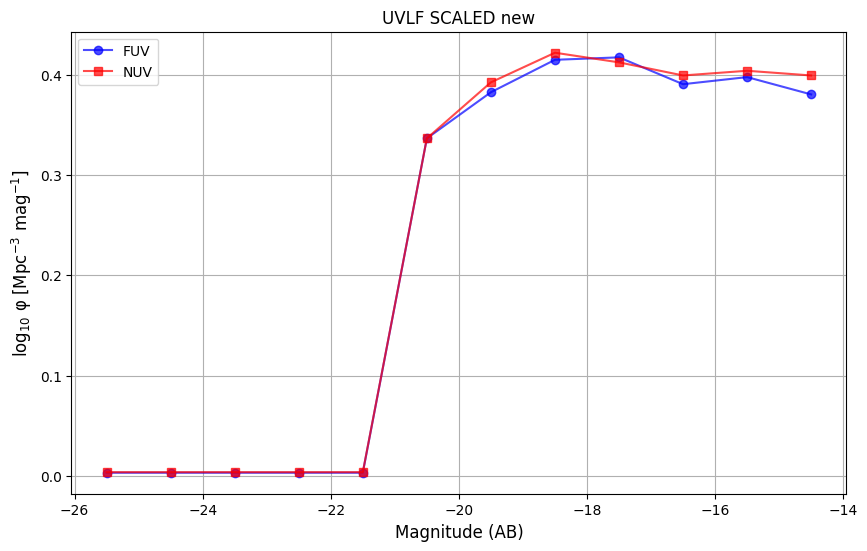

In [141]:
if luminosity_functions:
    fig = plot_uvlf(x_all_scaled_np)
    plt.savefig('/disk/xray15/aem2/plots/6pams/IllustrisTNG/LH/test/LFs_test/uvlf_check.png')
    plt.title('UVLF SCALED new')
    plt.show()

Color range: [-0.5, 3.5]
Distribution range: [0.02, 0.90]


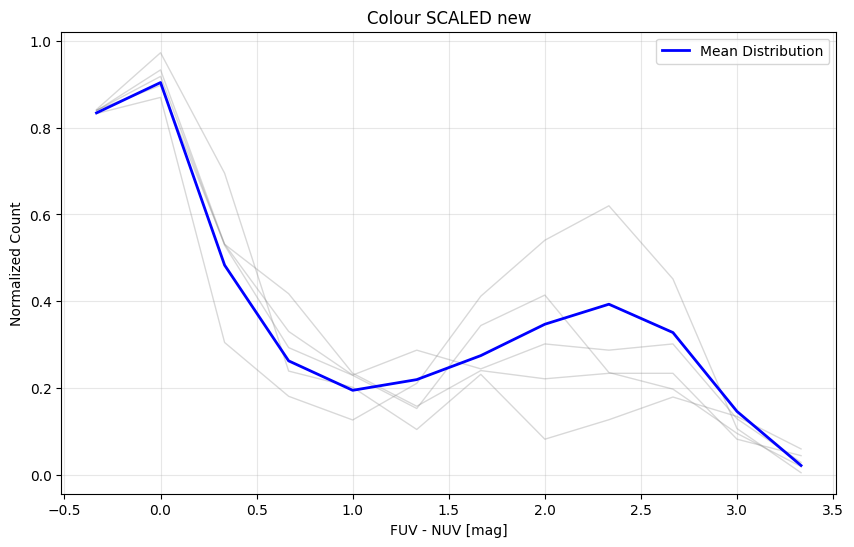

In [142]:
if colours:
    fig = plot_colour(x_all_scaled_np)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colour_check.png')
    plt.title('Colour SCALED new')
    plt.show()

Data shapes:
x_all shape: (1000, 36)
theta shape: (1000, 6)

X_all statistics:
Mean: 0.2744
Std: 0.2344
Min: 0.0000
Max: 1.0000

Theta statistics:

Parameter 1:
Mean: 0.3000
Std: 0.1155
Min: 0.1002
Max: 0.4998

Parameter 2:
Mean: 0.8000
Std: 0.1155
Min: 0.6002
Max: 0.9998

Parameter 3:
Mean: 1.3525
Std: 1.0221
Min: 0.2503
Max: 3.9945

Parameter 4:
Mean: 1.3525
Std: 1.0221
Min: 0.2503
Max: 3.9945

Parameter 5:
Mean: 1.0820
Std: 0.4263
Min: 0.5003
Max: 1.9986

Parameter 6:
Mean: 1.0820
Std: 0.4263
Min: 0.5003
Max: 1.9986


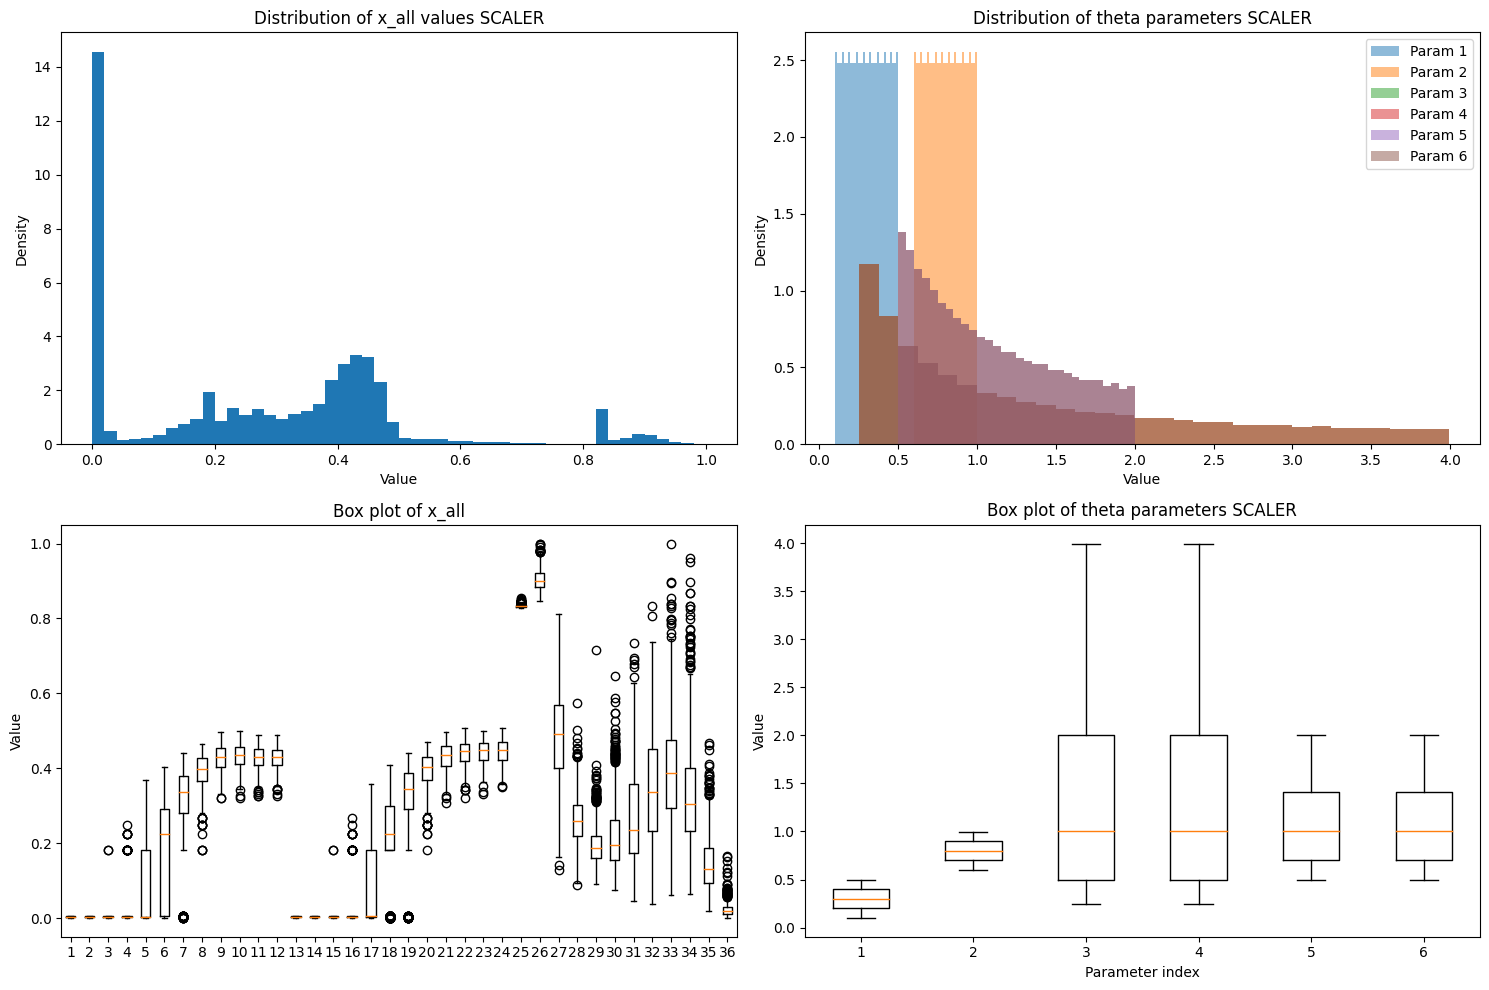

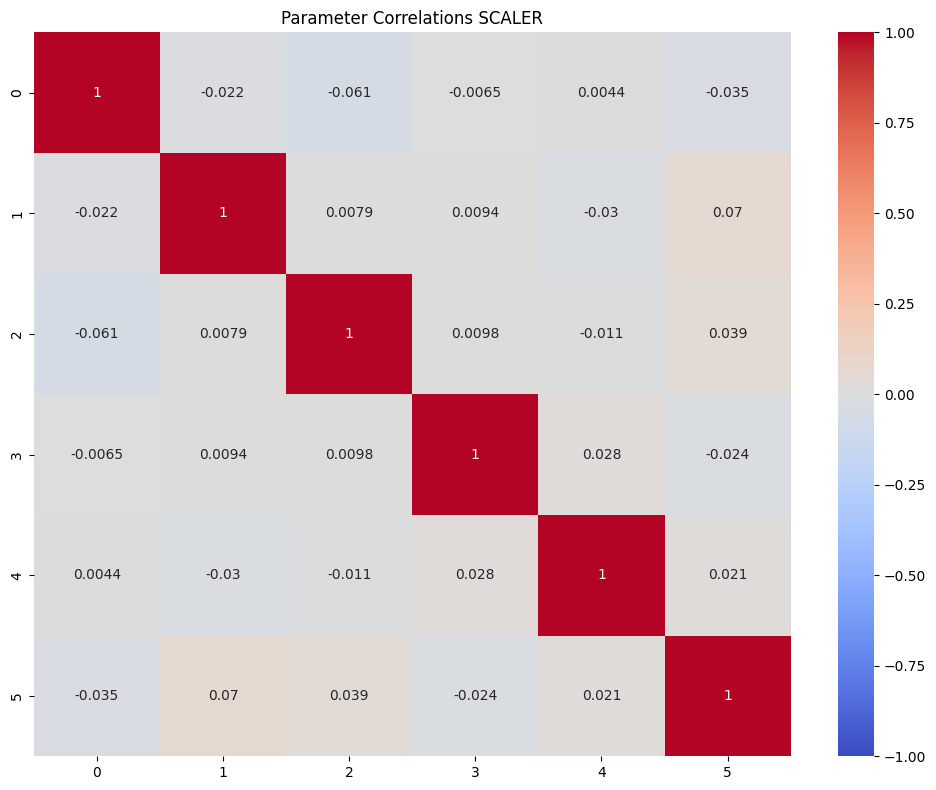

In [143]:

# Print basic statistics
print("Data shapes:")
print(f"x_all shape: {x_all_scaled_np.shape}")
print(f"theta shape: {theta_np.shape}")

print("\nX_all statistics:")
print(f"Mean: {x_all_scaled_np.mean():.4f}")
print(f"Std: {x_all_scaled_np.std():.4f}")
print(f"Min: {x_all_scaled_np.min():.4f}")
print(f"Max: {x_all_scaled_np.max():.4f}")

print("\nTheta statistics:")
for i in range(theta_np.shape[1]):
    print(f"\nParameter {i+1}:")
    print(f"Mean: {theta_np[:, i].mean():.4f}")
    print(f"Std: {theta_np[:, i].std():.4f}")
    print(f"Min: {theta_np[:, i].min():.4f}")
    print(f"Max: {theta_np[:, i].max():.4f}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot x_all distribution
axes[0,0].hist(x_all_scaled_np.flatten(), bins=50, density=True)
axes[0,0].set_title('Distribution of x_all values SCALER')
axes[0,0].set_xlabel('Value')
axes[0,0].set_ylabel('Density')

# Plot theta distributions
for i in range(theta_np.shape[1]):
    axes[0,1].hist(theta_np[:, i], bins=30, alpha=0.5, density=True, label=f'Param {i+1}')
axes[0,1].set_title('Distribution of theta parameters SCALER')
axes[0,1].set_xlabel('Value')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()

# Box plot for x_all
axes[1,0].boxplot(x_all_scaled_np)
axes[1,0].set_title('Box plot of x_all')
axes[1,0].set_ylabel('Value')

# Box plot for theta parameters
axes[1,1].boxplot([theta_np[:, i] for i in range(theta_np.shape[1])])
axes[1,1].set_title('Box plot of theta parameters SCALER')
axes[1,1].set_xlabel('Parameter index')
axes[1,1].set_ylabel('Value')

plt.tight_layout()
plt.show()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(np.corrcoef(theta_np.T), 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0)
plt.title('Parameter Correlations SCALER')
plt.tight_layout()
plt.show()

In [ ]:
x_test = x_all_scaled[test_mask].cpu()
theta_test = theta[test_mask].cpu()


In [191]:
# # Network architecture improvements
hidden_features = 60  # Increase from 30 for more capacity
num_transforms = 4    # Increase from 4 for more expressive transforms
num_nets = 2
# # num_bins = 10 # spline bins, this is default in sbi package anyway.

# Create larger ensemble
# Increase ensemble size and capacity slightly
nets = [
    ili.utils.load_nde_sbi(
        engine="NPE",
        model="nsf", 
        hidden_features=hidden_features,      # Reduce further for better σ8 and ASN1/2
        num_transforms=num_transforms,        # Reduce transforms for simpler model
    ) for _ in range(num_nets)         # Keep ensemble size
]

train_args = {
    "training_batch_size": 4,
    "learning_rate": 5e-4,      # Keep current LR
    "stop_after_epochs": 200,     # Keep early stopping criteria
    "max_num_epochs": 1000,       # Middle ground for epochs
    # "clip_max_norm": 0.8,       # Keep current clipping
    "validation_fraction": 0.1, # Keep current validation split
    "use_combined_loss": True,
    "show_train_summary": True,
    "dataloader_kwargs": {
        "num_workers": 0,
        "pin_memory": False
    }
}


# Keep the existing loader setup with scaled data
loader = NumpyLoader(
    x=x_all_scaled[~test_mask],
    theta=torch.tensor(theta[~test_mask, :], device=device)
)


runner = InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir="models/",
    name=name,
)


posterior_ensemble, summaries = runner(loader=loader)


/tmp/ipykernel_606161/2252564046.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta=torch.tensor(theta[~test_mask, :], device=device)
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


 Neural network successfully converged after 221 epochs.

INFO:root:Training model 2 / 2.



        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 221
        Best validation performance: 4.0071
        -------------------------
        
 Neural network successfully converged after 225 epochs.

INFO:root:It took 3286.336793899536 seconds to train models.
INFO:root:Saving model to models



        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 225
        Best validation performance: 3.6627
        -------------------------
        


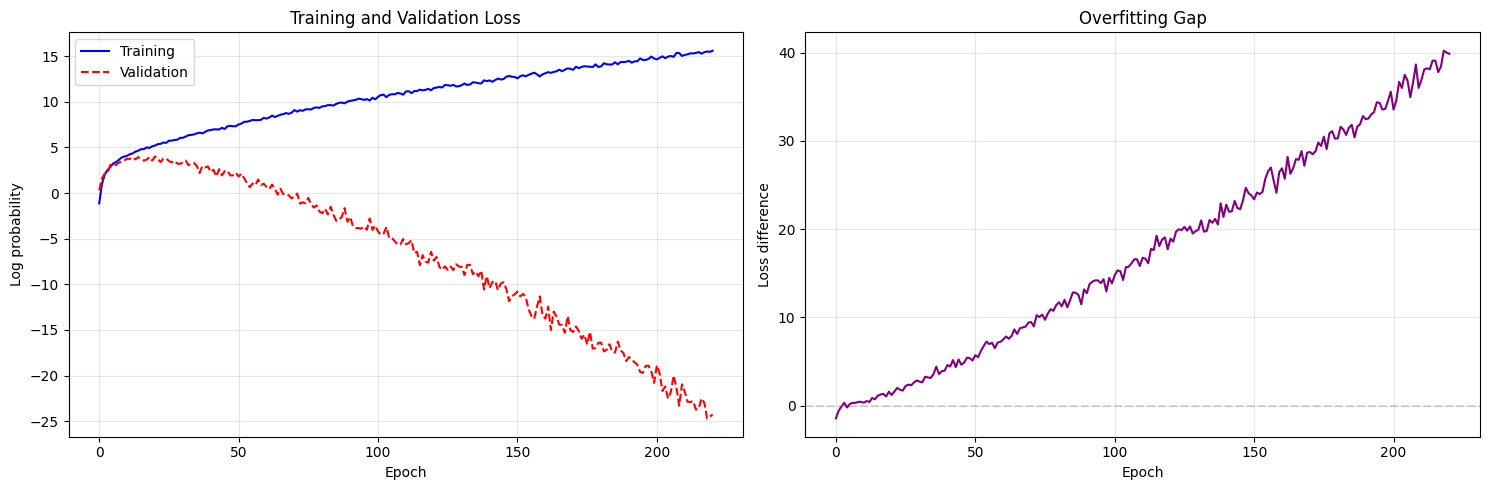

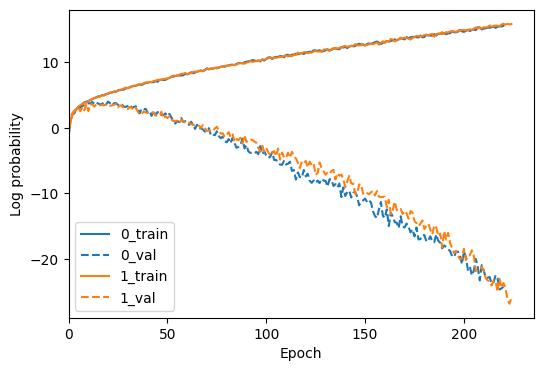

100%|██████████| 100/100 [00:05<00:00, 19.68it/s]
INFO:root:Mean logprob: 3.0553e+00Median logprob: 3.6762e+00
100%|██████████| 100/100 [00:00<00:00, 145.20it/s]


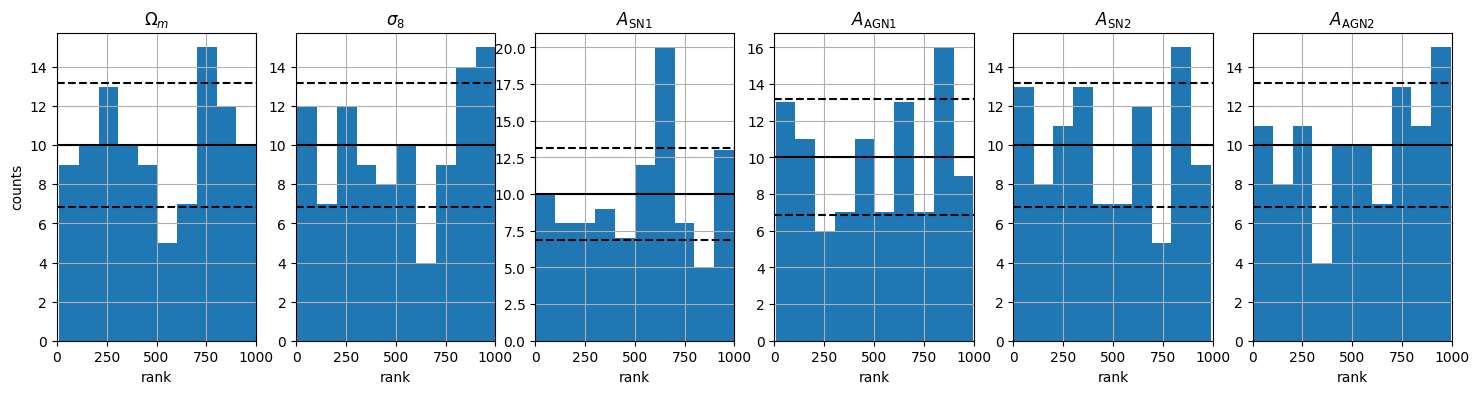

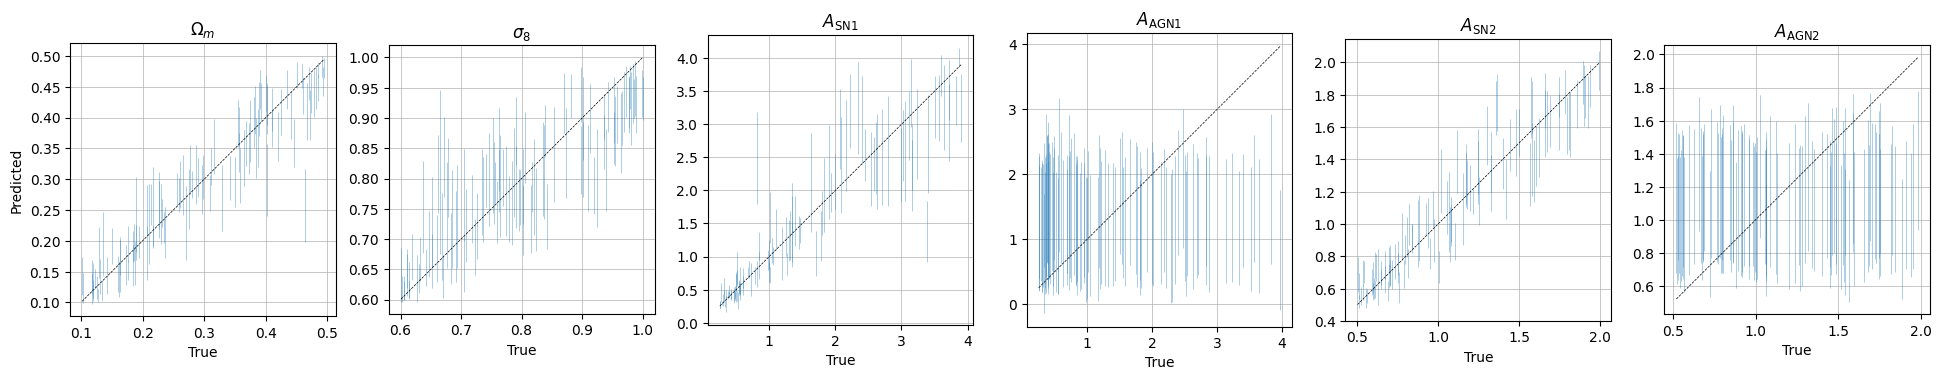

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


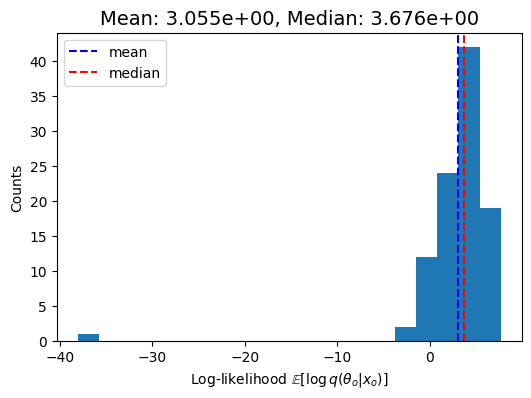

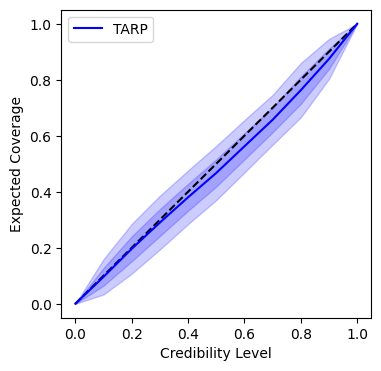

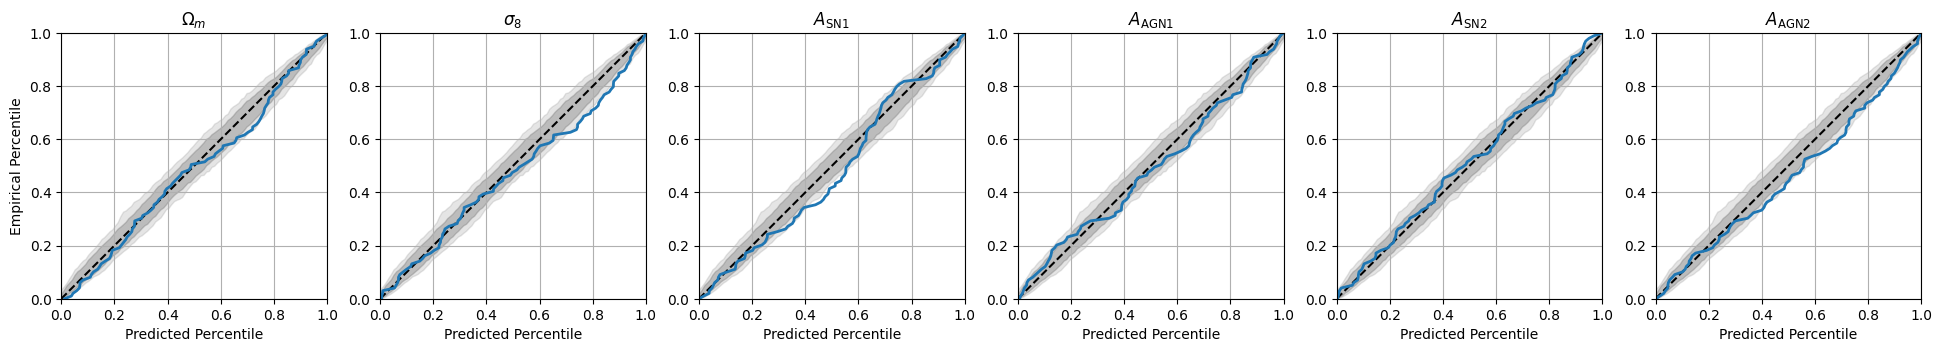

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

All plots saved in: /disk/xray15/aem2/plots/6pams/IllustrisTNG/LH/test/sbi_plots/colours_lfs/batch4_lr0.0005_epochs200_max_num_epochs1000_validation_fraction0.1_h60_t4_nn2


In [193]:
# Create config string for filenames
config_str = (f"batch{train_args['training_batch_size']}_"
             f"lr{train_args['learning_rate']}_"
             f"epochs{train_args['stop_after_epochs']}_"
             f"max_num_epochs{train_args['max_num_epochs']}_"
             f"validation_fraction{train_args['validation_fraction']}_"
            #  f"clip_max_norm{train_args['clip_max_norm']}_"
             f"h{hidden_features}_t{num_transforms}_nn{num_nets}")

# Create a new directory with the config string
config_plots_dir = os.path.join(plots_out_dir, config_str)
os.makedirs(config_plots_dir, exist_ok=True)

# First plot: Training diagnostics with two subplots
def plot_training_diagnostics(summaries):
    """Plot training diagnostics with loss and overfitting gap"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    train_losses = summaries[0]['training_log_probs']
    val_losses = summaries[0]['validation_log_probs']
    epochs = range(len(train_losses))
    
    ax1.plot(epochs, train_losses, '-', label='Training', color='blue')
    ax1.plot(epochs, val_losses, '--', label='Validation', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Log probability')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Overfitting gap
    gap = np.array(train_losses) - np.array(val_losses)
    ax2.plot(epochs, gap, '-', color='purple')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss difference')
    ax2.set_title('Overfitting Gap')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Second plot: Ensemble training curves
def plot_ensemble_training(summaries):
    """Plot training curves for each ensemble member"""
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    c = list(mcolors.TABLEAU_COLORS)
    for i, m in enumerate(summaries):
        ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
        ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
    ax.set_xlim(0)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log probability')
    ax.legend()
    return fig

# Save training plots in the new directory
fig1 = plot_training_diagnostics(summaries)
plt.savefig(os.path.join(config_plots_dir, f'training_analysis_{name}.png'),
            dpi=300, bbox_inches='tight')
plt.show()
plt.close()

fig2 = plot_ensemble_training(summaries)
plt.savefig(os.path.join(config_plots_dir, f'ensemble_training_{name}.png'),
            dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# # Create metric and get plots
# metric = PosteriorCoverage(
#     num_samples=int(1000),
#     sample_method='direct',
#     labels=cam.labels,
#     plot_list=["coverage", "histogram", "predictions", "tarp", "logprob"],
# )

# figs = metric(
#     posterior=posterior_ensemble,
#     x=x_test,
#     theta=theta_test,
#     signature=f"coverage_{name}_"
# )

# # Save metric plots in the config directory
# for plot_type in ["coverage", "histogram", "predictions", "tarp", "logprob"]:
#     # Find the corresponding file
#     source_file = None
#     for file in os.listdir(plots_out_dir):
#         if plot_type.lower() in file.lower() and file.endswith('.png'):
#             source_file = os.path.join(plots_out_dir, file)
#             # Copy to new location with new name
#             if os.path.exists(source_file):
#                 dest_file = os.path.join(config_plots_dir, f'{plot_type}_{name}.png')
#                 import shutil
#                 shutil.copy2(source_file, dest_file)
#                 # Optionally remove the original file
#                 os.remove(source_file)

# print(f"All plots saved in: {config_plots_dir}")

# Create metric and get plots
metric = PosteriorCoverage(
    num_samples=int(1000),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["coverage", "histogram", "predictions", "tarp", "logprob"], 
)

# # Instead of just using figs, let's save each figure explicitly
# def save_metric_plots(figs, plot_types, config_plots_dir, name):
#     for fig, plot_type in zip(figs, plot_types):
#         if fig is not None:
#             # Ensure the figure is a matplotlib figure
#             if hasattr(fig, 'savefig'):
#                 plot_path = os.path.join(config_plots_dir, f'{plot_type}_{name}.png')
#                 fig.savefig(plot_path, dpi=300, bbox_inches='tight')
#                 plt.close(fig)  # Close the figure to free up memory
#             else:
#                 print(f"Warning: {plot_type} figure is not a standard matplotlib figure")

# # Get the metric plots
# plot_types = ["coverage", "histogram", "predictions", "tarp", "logprob"]
# figs = metric(
#     posterior=posterior_ensemble,
#     x=x_test,
#     theta=theta_test,
#     signature=f"coverage_{name}_"
# )

# # Save the metric plots
# save_metric_plots(figs, plot_types, config_plots_dir, name)

# print(f"All plots saved in: {config_plots_dir}")

# Create metric and get plots
metric = PosteriorCoverage(
    num_samples=int(1000),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["coverage", "histogram", "predictions", "tarp", "logprob"], 
)

# Get the metric plots
plot_types = ["coverage", "histogram", "predictions", "tarp", "logprob"]
figs = metric(
    posterior=posterior_ensemble,
    x=x_test,
    theta=theta_test,
    signature=f"coverage_{name}_"
)

# Save and display the metric plots
def save_and_display_metric_plots(figs, plot_types, config_plots_dir, name):
    for fig, plot_type in zip(figs, plot_types):
        if fig is not None:
            # Ensure the figure is a matplotlib figure
            if hasattr(fig, 'savefig'):
                plot_path = os.path.join(config_plots_dir, f'{plot_type}_{name}.png')
                fig.savefig(plot_path, dpi=300, bbox_inches='tight')
                plt.figure(fig.number)  # Make this figure the current figure
                plt.show()  # Display the figure
                plt.close(fig)  # Close the figure to free up memory
            else:
                print(f"Warning: {plot_type} figure is not a standard matplotlib figure")

# Save and display the metric plots
save_and_display_metric_plots(figs, plot_types, config_plots_dir, name)

print(f"All plots saved in: {config_plots_dir}")

# Errors / Validation metrics

In [194]:
from ili.validation.metrics import PosteriorSamples

# Create the metric object
metric = PosteriorSamples(
    num_samples=int(1e4),  # 10,000 samples like your supervisor used
    sample_method="direct",
)

# Now use it to get posterior samples
psamps = metric(
    posterior=posterior_ensemble,
    x=x_all_scaled[test_mask].cpu().numpy(),
    theta=theta[test_mask].cpu().numpy(),
)

# Calculate the percentiles and metrics
perc = np.percentile(psamps, q=[16, 50, 84], axis=0)

# Calculate RMSE, epsilon, R², and χ²
rmse = np.sqrt(
    np.sum((theta.cpu().numpy()[test_mask, :] - perc[1, :, :])**2, axis=0) / 
    np.sum(test_mask)
)

# Mean relative error (epsilon)
mre = np.sum(
    ((perc[2, :, :] - perc[0, :, :]) / 2) / perc[1, :, :], axis=0
) / np.sum(test_mask)

# R-squared
theta_hat = np.sum(theta.cpu().numpy()[test_mask, :], axis=0) / np.sum(test_mask)
r2 = 1 - np.sum(
    (theta.cpu().numpy()[test_mask, :] - perc[1, :, :])**2, axis=0
) / np.sum(
    (theta.cpu().numpy()[test_mask, :] - theta_hat)**2, axis=0
)

# Chi-squared
chi2 = np.sum(
    (theta.cpu().numpy()[test_mask, :] - perc[1, :, :])**2 /
    ((perc[2, :, :] - perc[0, :, :]) / 2)**2, axis=0
) / np.sum(test_mask)

# Print results for each parameter
for i, param in enumerate(cam.labels):
    print(f"\nMetrics for {param}:")
    print(f"RMSE: {rmse[i]:.4f}")
    print(f"Epsilon: {mre[i]:.4f}")
    print(f"R²: {r2[i]:.4f}")
    print(f"χ²: {chi2[i]:.4f}")


import os

# Define the file path
metrics_file = os.path.join(config_plots_dir, f'metrics_{name}.txt')

# Write metrics to the file
with open(metrics_file, 'w') as f:
    for i, param in enumerate(cam.labels):
        f.write(f"\nMetrics for {param}:\n")
        f.write(f"RMSE: {rmse[i]:.4f}\n")
        f.write(f"Epsilon: {mre[i]:.4f}\n")
        f.write(f"R²: {r2[i]:.4f}\n")
        f.write(f"χ²: {chi2[i]:.4f}\n")

print(f"Metrics saved in: {metrics_file}")


100%|██████████| 100/100 [00:05<00:00, 18.53it/s]



Metrics for $\Omega_m$:
RMSE: 0.0371
Epsilon: 0.1295
R²: 0.9055
χ²: 0.9589

Metrics for $\sigma_8$:
RMSE: 0.0585
Epsilon: 0.0706
R²: 0.7782
χ²: 1.1258

Metrics for $A_{\mathrm{SN1}}$:
RMSE: 0.4267
Epsilon: 0.2151
R²: 0.8589
χ²: 1.3046

Metrics for $A_{\mathrm{AGN1}}$:
RMSE: 1.1350
Epsilon: 1.0555
R²: -0.2365
χ²: 1.5480

Metrics for $A_{\mathrm{SN2}}$:
RMSE: 0.1280
Epsilon: 0.1141
R²: 0.9170
χ²: 1.0339

Metrics for $A_{\mathrm{AGN2}}$:
RMSE: 0.4630
Epsilon: 0.4471
R²: -0.1475
χ²: 1.1413
Metrics saved in: /disk/xray15/aem2/plots/6pams/IllustrisTNG/LH/test/sbi_plots/colours_lfs/batch4_lr0.0005_epochs200_max_num_epochs1000_validation_fraction0.1_h60_t4_nn2/metrics_IllustrisTNG_all_BC03_attenuated_13_13.txt
